Installing the libraries

In [5]:
!pip install -q supervision ultralytics

Importing all the libraries which is used

In [6]:
import cv2
import numpy as np
import supervision as sv
from tqdm import tqdm
from ultralytics import YOLO
from collections import defaultdict, deque
import matplotlib.pyplot as plt

In [ ]:
model = YOLO('yolov8n.pt')    # Specifies the pre-trained YOLOv8n (YOLOv8 Nano) model weights to load.
model.train(data="/kaggle/input/vehicle-detection-dataset/No_Apply_Grayscale/No_Apply_Grayscale/Vehicles_Detection.v8i.yolov8/data.yaml", epochs=50, batch=16, imgsz=1280)
#Trains the YOLO model on the given dataset with the given parameters.

In [ ]:
# Evaluate the trained model on the validation set
results = model.val()
# Displaying results
print(results)


Defining the input(source) video path, ouput video path,confidence and IOU  threshold for detection and box selection,model and the resolution for the video frames


In [3]:
SOURCE_VIDEO_PATH = r"C:\Users\91878\Downloads\archive (4)\Vehicle_Detection_Image_Dataset\sample_video.mp4"
OUTPUT_VIDEO_PATH = "vehicles-result.mp4"
CONFIDENCE_THRESHOLD = 0.3
IOU_THRESHOLD = 0.5
MODEL_NAME = r"C:\Users\91878\Downloads\output\kaggle\working\runs\detect\train\weights\best.pt"    #best weights from the trained model
MODEL_RESOLUTION = 1280

Code for selecting the the coordinates(in sequence of top left-top-right-bottom-right-bottom left) and then press enter.
To be done by the user.


In [7]:

cap = cv2.VideoCapture(SOURCE_VIDEO_PATH)

# To Check if the video was successfully opened
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Read a single frame from the video
ret, frame = cap.read()

# If a frame was successfully read, proceed
if ret:
    # Initialize an empty list to store coordinates before converting to a NumPy array
    coordinates = []

    # Define the click event
    def click_event(event, x, y, flags, params):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Append the coordinates to the list
            coordinates.append([x, y])
            print(f"Clicked at: ({x}, {y})")

            # Draw a circle at the clicked position
            cv2.circle(frame, (x, y), 5, (255, 0, 0), -1)
            cv2.imshow("Frame", frame)

    # Display the frame and bind the click event
    cv2.imshow("Frame", frame)
    cv2.setMouseCallback("Frame", click_event)

    # Wait indefinitely until a key is pressed
    cv2.waitKey(0)

    # Destroy all OpenCV windows
    cv2.destroyAllWindows()

    # Convert the list of coordinates to a NumPy array
    SOURCE = np.array(coordinates)

    # Display the coordinates in 'SOURCE' array
    print("Collected coordinates (SOURCE array):")
    print(SOURCE)
else:
    print("Error: Could not read the frame from the video.")

# Release the video capture object
cap.release()


Clicked at: (488, 326)
Clicked at: (784, 319)
Clicked at: (1196, 616)
Clicked at: (63, 593)
Collected coordinates (SOURCE array):
[[ 488  326]
 [ 784  319]
 [1196  616]
 [  63  593]]


Defining actual target(region of interest) coordinates in metre(m) in the given sequence previously.

In [11]:


TARGET_WIDTH = 20
TARGET_HEIGHT = 150

TARGET = np.array([
    [0, 0],
    [TARGET_WIDTH - 1, 0],
    [TARGET_WIDTH - 1, TARGET_HEIGHT - 1],
    [0, TARGET_HEIGHT - 1],
])
print(TARGET)

[[  0   0]
 [ 19   0]
 [ 19 149]
 [  0 149]]


Getting the first frame

In [9]:

def get_video_frames_generator(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        yield frame
    cap.release()

# Initialize the frame generator
frame_generator = get_video_frames_generator(SOURCE_VIDEO_PATH)

# Get the first frame
frame = next(frame_generator)


Region of Interest

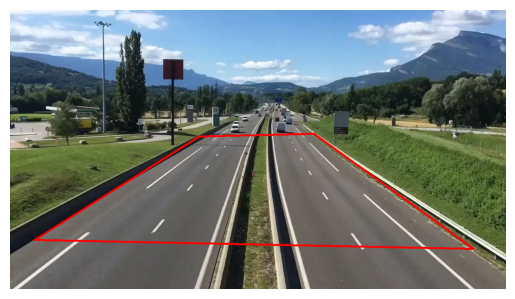

In [10]:

# Annotate the frame
annotated_frame = frame.copy()

# Draw the polygon
color = (0, 0, 255)  # Red color in BGR format
thickness = 4
cv2.polylines(annotated_frame, [SOURCE], isClosed=True, color=color, thickness=thickness)

# Plot the image
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for plotting
plt.axis("off")  # Hide axes
plt.show()


Perspective Tranformation

In [ ]:
#Computes the perspective transformation matrix that maps points from one plane (source) to another (target).
def get_perspective_transform(source: np.ndarray, target: np.ndarray) -> np.ndarray:
    source = source.astype(np.float32)
    target = target.astype(np.float32)
    return cv2.getPerspectiveTransform(source, target)

# Applies a perspective transformation matrix to a set of points to map them from the source plane to the target plane.
def transform_points(points: np.ndarray, transformation_matrix: np.ndarray) -> np.ndarray:
    if points.size == 0:
        return points

    reshaped_points = points.reshape(-1, 1, 2).astype(np.float32)
    transformed_points = cv2.perspectiveTransform(reshaped_points, transformation_matrix)
    return transformed_points.reshape(-1, 2)

transformation_matrix = get_perspective_transform(SOURCE, TARGET)

In [ ]:
import numpy as np
import supervision as sv
from collections import defaultdict, deque
from tqdm import tqdm

# Get the perspective transformation matrix
transformation_matrix = get_perspective_transform(SOURCE, TARGET)

# Setup for ByteTrack and video processing
video_info = sv.VideoInfo.from_video_path(video_path=SOURCE_VIDEO_PATH)
frame_generator = sv.get_video_frames_generator(source_path=SOURCE_VIDEO_PATH)

# tracer initiation
byte_track = sv.ByteTrack(
    frame_rate=video_info.fps, track_activation_threshold=CONFIDENCE_THRESHOLD
)
model = YOLO(MODEL_NAME)

# annotators configuration
thickness = sv.calculate_optimal_line_thickness(resolution_wh=video_info.resolution_wh)
text_scale = sv.calculate_optimal_text_scale(resolution_wh=video_info.resolution_wh)
bounding_box_annotator = sv.BoundingBoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_scale=text_scale,
    text_thickness=thickness,
    text_position=sv.Position.BOTTOM_CENTER
)
trace_annotator = sv.TraceAnnotator(
    thickness=thickness,
    trace_length=video_info.fps * 2,
    position=sv.Position.BOTTOM_CENTER
)

# Initialize the PolygonZone with the polygon and the default triggering anchor
polygon_zone = sv.PolygonZone(SOURCE)

coordinates = defaultdict(lambda: deque(maxlen=video_info.fps))

# Vehicle class names (customize these based on your model's classes)
class_names = {
    0: "Bus",
    1: "Car",
    2: "Motercycle",
    3: "Pickup",
    4: "Truck",

}
# Open target video
with sv.VideoSink(OUTPUT_VIDEO_PATH, video_info) as sink:
    # Loop over source video frame
    for frame in tqdm(frame_generator, total=video_info.total_frames):
        # Get detection results from the model
        result = model(frame, imgsz=MODEL_RESOLUTION, verbose=False)[0]
        detections = sv.Detections.from_ultralytics(result)

        # Filter out detections by class and confidence
        detections = detections[detections.confidence > CONFIDENCE_THRESHOLD]

        # Filter out detections outside the zone
        detections = detections[polygon_zone.trigger(detections)]

        # Refine detections using non-max suppression
        detections = detections.with_nms(IOU_THRESHOLD)

        # Pass detection through the tracker
        detections = byte_track.update_with_detections(detections=detections)

        # Get anchor points
        points = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)

        # Calculate the detections position inside the target Region of Interest
        points = transform_points(points=points, transformation_matrix=transformation_matrix).astype(int)

        # Store detections position
        for tracker_id, [_, y] in zip(detections.tracker_id, points):
            coordinates[tracker_id].append(y)

        # Format labels
        labels = []
        for tracker_id, class_id, confidence in zip(detections.tracker_id, detections.class_id, detections.confidence):
            # Fetch the class name
            class_name = class_names.get(class_id, "Unknown")

            # Get the tracker ID and class name
            label = f"#{tracker_id} {class_name} ({confidence:.2f})"  # Format confidence to 2 decimal places

            if len(coordinates[tracker_id]) < video_info.fps / 2:
                labels.append(label)
            else:
            # Calculate speed
                coordinate_start = coordinates[tracker_id][-1]
                coordinate_end = coordinates[tracker_id][0]
                distance = abs(coordinate_start - coordinate_end)
                time = len(coordinates[tracker_id]) / video_info.fps
                speed = distance / time * 3.6  # Speed in km/h

                # Check if the speed is over the threshold
                overspeed_tag = " [Overspeed]" if speed > 110 else ""
                labels.append(f"{label} {int(speed)} km/h{overspeed_tag}")



        # Annotate frame
        annotated_frame = frame.copy()
        annotated_frame = trace_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = bounding_box_annotator.annotate(scene=annotated_frame, detections=detections)
        annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

        # Add frame to target video
        sink.write_frame(annotated_frame)


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.
100%|██████████| 538/538 [00:53<00:00, 10.10it/s]
